# 2.03c - Analysis of Night Clusters and BG
This notebook is used to analyse the night clusters and look for indications of BG control during the night.


In [1]:
from IPython.core.pylabtools import figsize
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from datetime import time
from scipy.stats import ttest_ind

from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.dba import get_dba_and_variance
from src.reliationship_modelling import AnalyseRelationships

2025-07-06 20:32:19.203 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [27]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all[['night_start_date', 'bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max', 'tsne_cluster_label']].rename(columns={'tsne_cluster_label': 'cluster'})
df_all['bg_min_excursion'] = df_all['bg min'].apply(lambda x: (x - bg_min) if x < bg_min else np.nan)
df_all['bg_max_excursion'] = df_all['bg max'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)
df_all['bg_excursion'] = df_all[['bg_min_excursion', 'bg_max_excursion']].apply(lambda x: x['bg_min_excursion'] if pd.notna(x['bg_min_excursion']) else x['bg_max_excursion'], axis=1)
df_all['bg_excursion_type'] = df_all['bg_excursion'].apply(lambda x: 'IBR' if x < 0 else 'IAR' if x > 0 else np.nan)

night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

2025-07-06 22:14:16.033 | INFO     | src.nights:_calculate_overall_stats:158 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   1%|          | 38/6454 [00:00<00:16, 379.63it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  10%|▉         | 620/6454 [00:00<00:08, 712.80it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 695/6454 [00:01<00:08, 718.93it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: Runtime

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'iob max__count_above__t_100', 'cob mean__minimum', 'cob max__minimum'}
PCA reduced dimensions from 75 to 2.


We'll first look to see if there is any prevalence of BG excursions in the night clusters. Sleep is considered key to maintaining optimal cardiovascular and metabolic health. The relationship between sleep and glyaecemic control is complex and bi-directional. The effects of disrupted sleep on glucose control \cite{Farabi2016} and - conversely - impact of diabetes treatment on sleep \cite{Brod2013} have been studied but require more research. For instance, studies have associated the rapid decline in blood glucose over short periods with awakenings from sleep \cite{Pillar2003}, but little is known about causation.

By studying the amount of excursions outside a target glucose range, we can get an idea as to the frequency and extent of these excursions. Based on the assumptions given by other research, such excursions may infer - by association - some form of disturbance of sleep. Setting accurate thresholds is not possible when generalising over individuals. Time in range is a good indicator of BG control, but the definition of the ideal range is highly individual. For adults in the UK for a target range is between 3.9–10 mmol/l (or 3.5–7.8 mmol/l during pregnancy). We do not have data on whether our patients are in gestation to adjust the target accordingly and therefore assume a consistent 3.9-10 mmol/l (70-180 mg/dL) concentration range as a general guideline, but this would normally be adjusted for individual needs.

The period we will consider studying once more is the 22:00-06:00 period as defining an arbitrary 'nocturnal' period. This is a period where we would expect the patient to be asleep and therefore not consuming food or taking insulin. Given our intervals are at 30 minutes we cannot accurately measure TOR, but we can look at intervals outside the target range, as well as the level of excursion above or below the target. At each interval we can focus on the BG min and max values at each interval which will have captured the peaks and troughs without smoothing these values, especially if short-lived. We know the OpenAPS system effectively manages BG in patients, so we would expect to see a lower number of excursions in the night clusters compared to the day clusters.

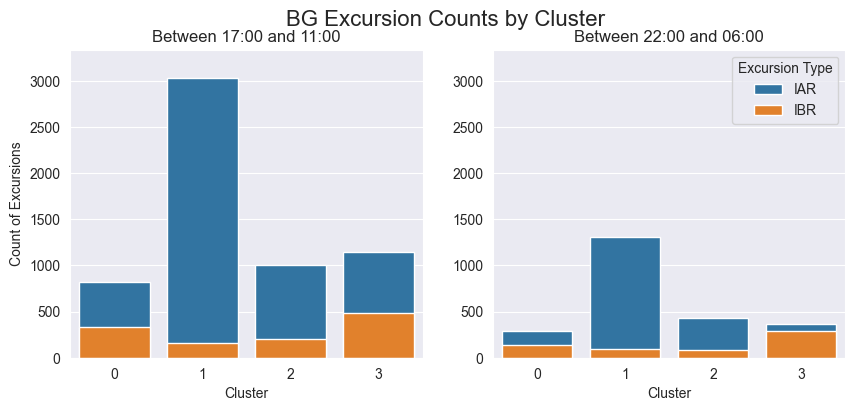

In [39]:
bg_min = 70
bg_max = 180


fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('BG Excursion Counts by Cluster', fontsize=16)
df_all_excursion_summary = df_all.groupby(['cluster', 'bg_excursion_type'])['bg_excursion'].count().reset_index()
df_overnight_excursion_summary = df_overnight.groupby(['cluster', 'bg_excursion_type'])['bg_excursion'].count().reset_index()
y_max = df_all_excursion_summary['bg_excursion'].max()
sns.barplot(df_all_excursion_summary, x='cluster', y='bg_excursion', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)

sns.barplot(df_overnight_excursion_summary, x='cluster', y='bg_excursion', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)

axes[1].legend(title='Excursion Type')
plt.show()


In [21]:
df_excursion_summary

cluster  bg_excursion_type
0        IAR                   823
         IBR                   338
1        IAR                  3035
         IBR                   156
2        IAR                  1003
         IBR                   202
3        IAR                  1149
         IBR                   490
Name: bg_excursion, dtype: int64